In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2') 


## Predicting Average Food Prices

In [308]:
data=pd.read_excel("./data/madde sepeti ve ortalama madde fiyatlari (turkiye).xls")
food=data.iloc[5:133]
food


,Tüketici fiyat endeksi (2003=100) madde sepeti ve ortalama fiyatlar (Türkiye),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234
5,0111101,Pirinç,Rice,2016210,2035962,2065616,2097533,2117020,2125184,2135285,...,12.9481,12.984,13.0078,12.8113,13.0396,14.8318,14.8289,15.1403,15.1767,16.5981
6,0111201,Buğday Unu,Wheat flour,952642,962023,981226,1001251,1010282,1012034,1017230,...,5.4512,5.3747,5.4669,5.8428,6.6307,9.5536,8.9233,9.19,9.5583,10.3459
7,0111208,Bebek Sütü (Toz Karışım),Baby food,35681369,35706034,35752192,36034235,36137923,36220300,36416760,...,148.9501,150.5066,151.3812,151.5265,157.4898,166.8686,160.91,161.5983,157.4953,155.4234
8,0111209,Bulgur,Boiled and pounded wheat,985961,996150,1015331,1041581,1052962,1060421,1064402,...,6.2007,6.4358,6.5743,6.9804,7.3841,8.93,10.1402,10.8659,10.5602,10.7178
9,0111301,Ekmek,Bread,1033435,1045493,1068880,1095853,1107608,1119798,1128075,...,7.8771,8.0266,8.279,8.4959,9.0969,10.7633,11.3447,11.7953,12.7932,13.7356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0122202,Gazoz Meyveli,Carbonated fruity beverages,1388517,1392302,1393665,1403683,1441246,1444682,1443598,...,4.7256,4.7629,4.9675,5.1736,5.2249,5.4135,5.725,6.4382,6.8085,7.6764
129,0122203,Kola,Coke,1507574,1510682,1509274,1518258,1565513,1572362,1565559,...,5.1188,5.1452,5.3898,5.6556,5.749,6.0229,6.2032,7.0071,7.2763,8.5608
130,0122204,Soğuk Çay,Ice tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.6003,5.7153,5.8004,5.9331,6.1344,6.4363,6.8291,7.9885,8.3475,10.023
131,0122205,Ayran,Ayran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0355,5.4031,5.4003,5.3821,5.3845,6.4625,7.194,7.005,6.7645,8.3122


In [309]:
#Creating a Time Serie
dates= pd.date_range('2003-01-01','2022-05-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()
df["TIME"]=dates
m=food.iloc[0:129,3:236].mean(axis=0)
df["Value"]=m.values
df

,TIME,Value
0,2003-01-01,4.354066e+06
1,2003-02-01,4.403930e+06
2,2003-03-01,4.493635e+06
3,2003-04-01,4.413601e+06
4,2003-05-01,4.408923e+06
...,...,...
227,2021-12-01,3.321774e+01
228,2022-01-01,3.598280e+01
229,2022-02-01,3.856380e+01
230,2022-03-01,3.935581e+01


In [310]:
df.iloc[0:24,1]=df.iloc[0:24,1]/1e+6
df=df.set_index(dates)
df

,TIME,Value
2003-01-01,2003-01-01,4.354066
2003-02-01,2003-02-01,4.403930
2003-03-01,2003-03-01,4.493635
2003-04-01,2003-04-01,4.413601
2003-05-01,2003-05-01,4.408923
...,...,...
2021-12-01,2021-12-01,33.217742
2022-01-01,2022-01-01,35.982803
2022-02-01,2022-02-01,38.563805
2022-03-01,2022-03-01,39.355813


In [9]:
df.info()   # time as object, need convert to data_time format

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2003-01-01 to 2022-04-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    232 non-null    datetime64[ns]
 1   Value   232 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


In [311]:
df['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df['TIME'] =  pd.to_datetime(df['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['TIME'])

In [11]:
df.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='TIME', length=232, freq=None)

In [312]:
df[pd.isnull(df['Value'])].count()
df['Value']=df['Value'].astype(float)


Text(0.5, 1.0, 'Average Food Prices(₺)')

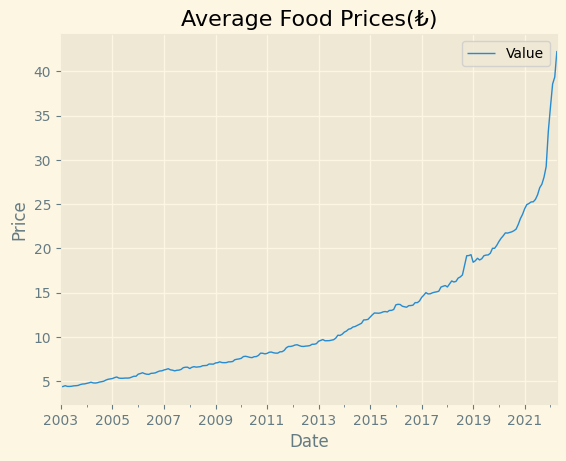

In [313]:
# Resulting Plot
df.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")

In [14]:
df.Value

TIME
2003-01-01     4.354066
2003-02-01     4.403930
2003-03-01     4.493635
2003-04-01     4.413601
2003-05-01     4.408923
                ...    
2021-12-01    33.217742
2022-01-01    35.982803
2022-02-01    38.563805
2022-03-01    39.355813
2022-04-01    42.303279
Name: Value, Length: 232, dtype: float64

In [314]:
# Test stationarity for model selection

from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df.Value)

Test Statistic                  -0.552569
p-value                          0.881343
#Lags Used                      12.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64

For model selection we used adfuller test. Time series are stationary if they do not have trend or seasonal effects, otherwire considered as not-stationary. For not-stationary time series best fit SARIMAX model. 

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Null Hypothesis is failed to be rejected by Dickey-Fuller test and gave a result of Test statistical value -0.552569, which is higher than Critical value (10%). That is also indicated by p-value 0.881343 (p-value > 0.05), meaning, that out time series are not-stationary, having strong seasonal effects and we will fit SARIMAX model.

  

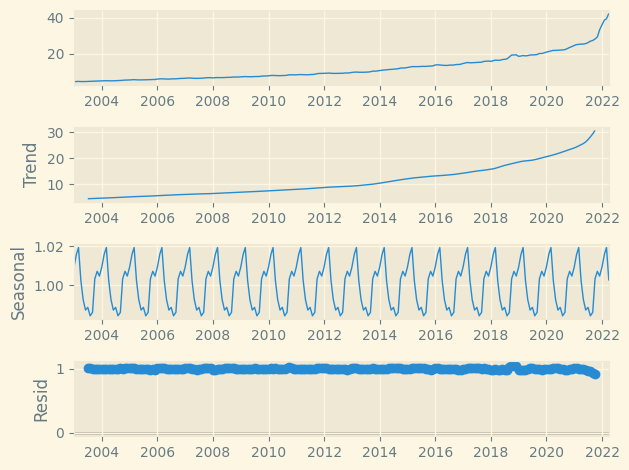

In [315]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')



plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available)

In [17]:
#Import Arima Model
from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=127.238, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=240.186, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=142.588, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=191.334, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=129.449, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=126.115, Time=0.72 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=126.817, Time=0.33 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=128.066, Time=2.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=127.763, Time=3.18 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=129.233, Time=1.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=127.999, Time=0.86 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=126.270, Time=4.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=192.553, Time=0.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=142.752, Time=0.39 sec
 ARIMA(2,1,1)(1,1,1)[12]         

In [18]:
results.aic()

115.59514238430849

SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.Trend Elements: p- Trend autoregression order, d - Trend difference order, q - Trend moving average order. Seasonal Elements: P - Seasonal autoregressive order ,D - Seasonal difference order, Q - Seasonal moving average order and m - The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q)m
               
We used Auto Arima for automaticly identifying best hyperparameters for the trend and seasonal elements. And  the Model perform best with lowest AIC of 2377.4812, using Trend Elements 1, 1, 1 and Seasonal Elements - - 0, 1, 0, where m - 12. Those hyperparameters we will fit into the SARIMAX.

In [316]:
#Import Sarima Model
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df.astype(float),
                                order=(3,1,2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()



c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


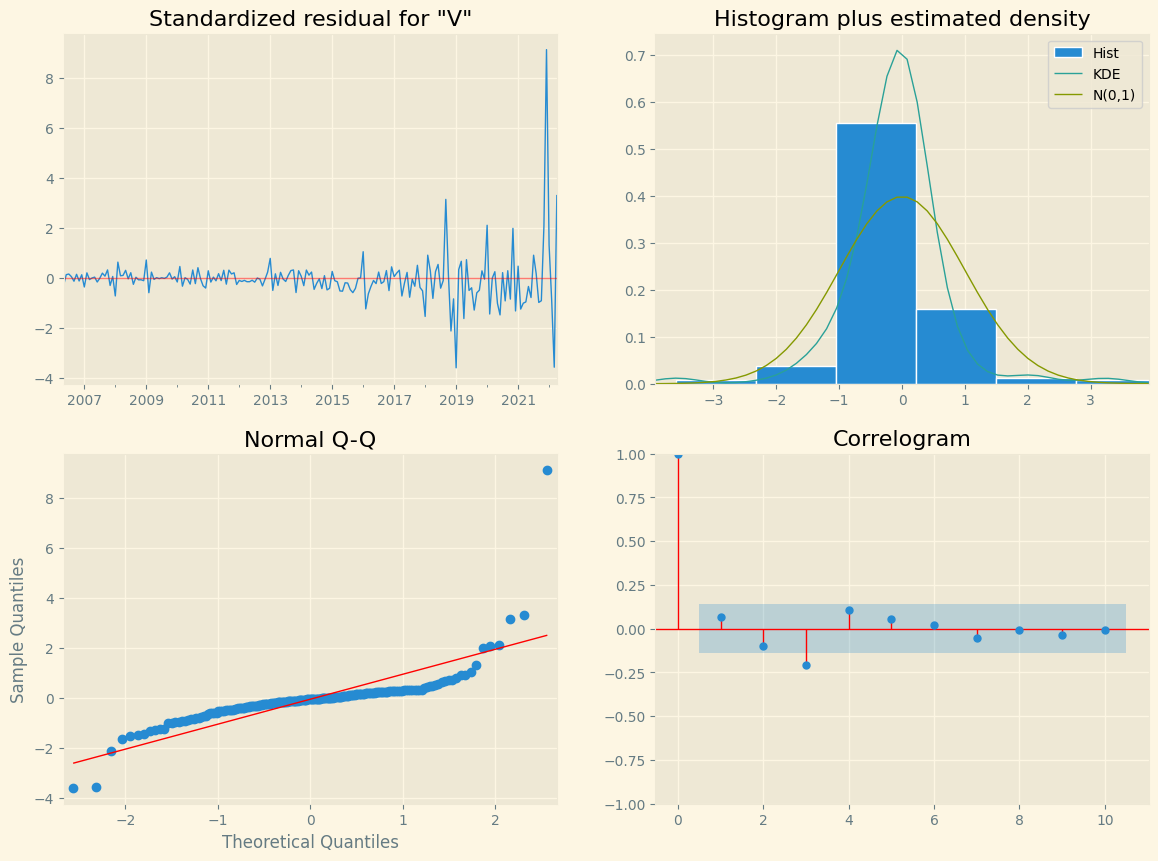

In [317]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

In [318]:
#Creating prediction 
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [319]:
#Creating Predicted Mean Values
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2021-07-01,25.205538,26.371520,25.788529,26.057374,-1.031743
2021-08-01,26.222627,27.388384,26.805505,26.855520,-0.186237
2021-09-01,26.958032,28.123779,27.540906,27.248159,1.074370
2021-10-01,27.736636,28.902178,28.319407,28.046824,0.971885
2021-11-01,28.043312,29.208842,28.626077,29.239670,-2.098493
2021-12-01,29.922774,31.088116,30.505445,33.217742,-8.165205
2022-01-01,35.010146,36.175474,35.592810,35.982803,-1.083833
2022-02-01,38.245661,39.410850,38.828255,38.563805,0.685748
2022-03-01,39.835567,41.000749,40.418158,39.355813,2.699334
2022-04-01,40.735621,41.900577,41.318099,42.303279,-2.328851


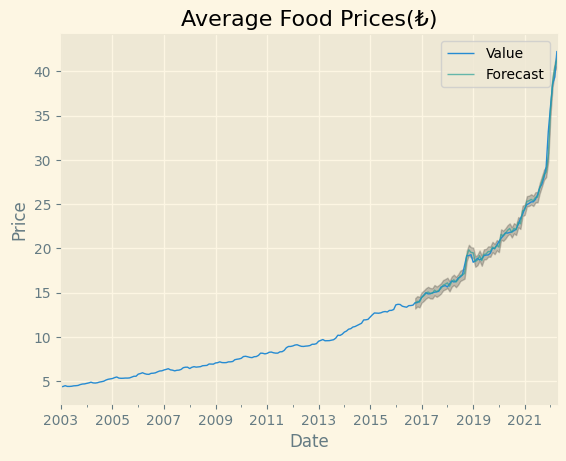

In [320]:
#Plotting value vs forecast
ax = df['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")
plt.legend()
plt.show()

In [324]:
# Get forecast
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

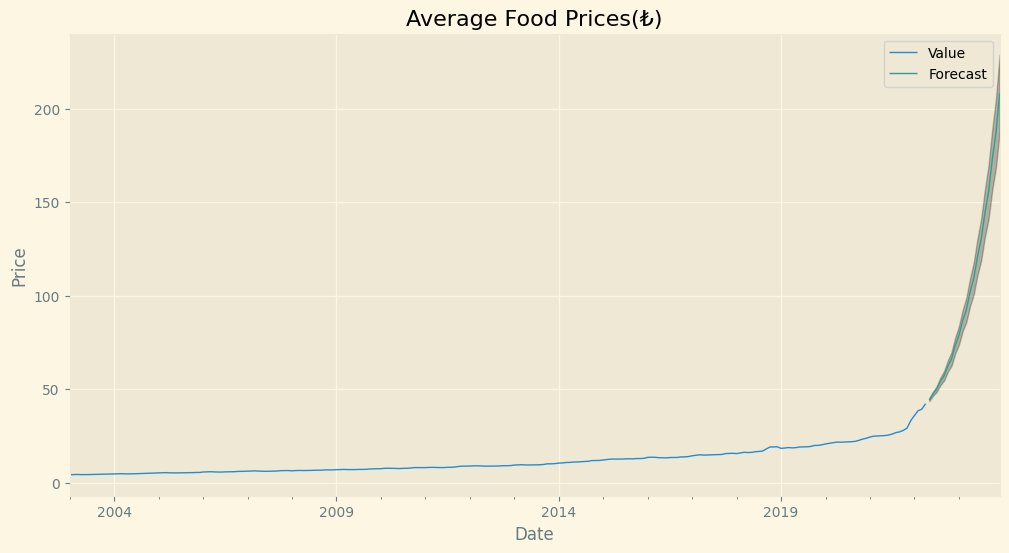

In [325]:
ax = df.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")

plt.legend()

plt.show()

In [326]:
#Lower and upper values for prediction
pred_ci

,lower Value,upper Value
2022-05-01,43.709845,44.874793
2022-06-01,46.545502,48.635021
2022-07-01,48.561360,51.649828
2022-08-01,52.168059,56.200946
2022-09-01,54.671846,59.749492
2022-10-01,59.229036,65.345470
2022-11-01,62.550910,69.847277
2022-12-01,69.076292,77.581324
2023-01-01,73.789032,83.683972
2023-02-01,80.947525,92.290253


Text(0.5, 1.0, 'Average Food Prices(₺)')

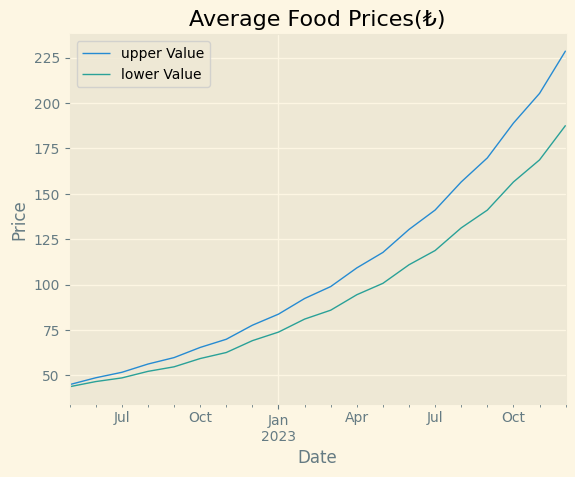

In [327]:
#Plotting upper and lower values
pred_ci[["upper Value","lower Value"]].head(24).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")

In [328]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [329]:
pred_ci['Mean'].head(20)



2022-05-01     44.292319
2022-06-01     47.590262
2022-07-01     50.105594
2022-08-01     54.184503
2022-09-01     57.210669
2022-10-01     62.287253
2022-11-01     66.199093
2022-12-01     73.328808
2023-01-01     78.736502
2023-02-01     86.618889
2023-03-01     92.363611
2023-04-01    101.755622
2023-05-01    109.155819
2023-06-01    120.600351
2023-07-01    129.857041
2023-08-01    143.836152
2023-09-01    155.341273
2023-10-01    172.667606
2023-11-01    186.925402
2023-12-01    208.198228
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'Average Food Prices(₺) Prediction for next 24 months')

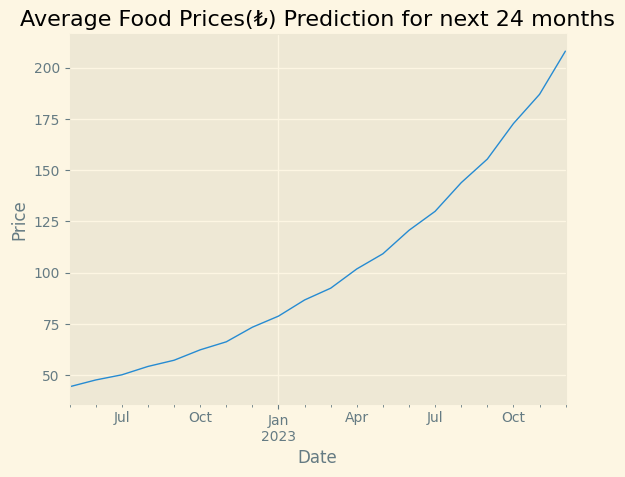

In [330]:
#Plotting predicted mean values
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺) Prediction for next 24 months")

In [331]:
food_predicted=pred_ci["Mean"]

In [67]:
#Creating currency data
currency=pd.read_csv("./data/USD_TRY Geçmiş Verileri.csv")
currency=pd.DataFrame(currency["Şimdi"])
currency=currency.applymap(lambda x: str(x.replace(',','.')))
currency=currency.astype(float)
currency1=pd.DataFrame(currency.loc[:231])
currency1

,Şimdi
0,1.6500
1,1.5970
2,1.7155
3,1.5657
4,1.4290
...,...
227,13.3161
228,13.3074
229,13.8443
230,14.6700


In [68]:
#Creating currency time serie
df1=pd.DataFrame()
df1["Value"]=currency1
df1["TIME"]=dates
df1['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df1['TIME'] =  pd.to_datetime(df1['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df1 = df1.set_index(['TIME'])
df1

,Value
TIME,
2003-01-01,1.6500
2003-02-01,1.5970
2003-03-01,1.7155
2003-04-01,1.5657
2003-05-01,1.4290
...,...
2021-12-01,13.3161
2022-01-01,13.3074
2022-02-01,13.8443


In [205]:
brent=pd.read_csv("./data/Brent Petrol Vadeli İşlemleri Geçmiş Verileri.csv")
brent=brent["Şimdi"]
brent=brent.str.replace(',','.')
brent=brent.astype(float)
brent1=pd.DataFrame(brent.loc[:231])
brent1

,Şimdi
0,31.10
1,32.79
2,27.18
3,23.68
4,26.32
...,...
227,77.35
228,89.26
229,97.97
230,104.71


In [206]:
#Creating brent petrol time serie
df2=pd.DataFrame()
df2["Value"]=brent1["Şimdi"]
df2["TIME"]=dates
df2['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df2['TIME'] =  pd.to_datetime(df2['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df2 = df2.set_index(['TIME'])
df2


,Value
TIME,
2003-01-01,31.10
2003-02-01,32.79
2003-03-01,27.18
2003-04-01,23.68
2003-05-01,26.32
...,...
2021-12-01,77.35
2022-01-01,89.26
2022-02-01,97.97


In [35]:
#Creating Electricty price time serie
elektrik=data[data['Unnamed: 1']=='Elektrik Ücreti']
elektrik=elektrik.T
elektrik=elektrik.iloc[3:,:]
elektrik=elektrik.astype(float)
elektrik.iloc[0:24]=elektrik.iloc[0:24]/1e+6
elektrik

,206
Unnamed: 3,0.157838
Unnamed: 4,0.157838
Unnamed: 5,0.157589
Unnamed: 6,0.155600
Unnamed: 7,0.155600
...,...
Unnamed: 230,0.917200
Unnamed: 231,1.556200
Unnamed: 232,1.480900
Unnamed: 233,1.337200


In [36]:
df3=pd.DataFrame()
df3["Value"]=elektrik
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3



,Value
TIME,
2003-01-01,0.157838
2003-02-01,0.157838
2003-03-01,0.157589
2003-04-01,0.155600
2003-05-01,0.155600
...,...
2021-12-01,0.917200
2022-01-01,1.556200
2022-02-01,1.480900


In [37]:
#Creating Natural Gas Price Time Serie
doğalgaz=data[data['Unnamed: 1']=='Doğalgaz Ücreti']
doğalgaz=doğalgaz.T
doğalgaz=doğalgaz.iloc[3:,:]
doğalgaz=doğalgaz.astype(float)
doğalgaz.iloc[0:24]=doğalgaz.iloc[0:24]/1e+6
doğalgaz

,207
Unnamed: 3,0.387655
Unnamed: 4,0.387773
Unnamed: 5,0.387773
Unnamed: 6,0.387593
Unnamed: 7,0.432088
...,...
Unnamed: 230,2.275700
Unnamed: 231,2.751500
Unnamed: 232,2.841100
Unnamed: 233,2.907100


In [38]:
df4=pd.DataFrame()
df4["Value"]=doğalgaz
df4["TIME"]=dates
df4['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df4['TIME'] =  pd.to_datetime(df4['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df4 = df4.set_index(['TIME'])
df4

,Value
TIME,
2003-01-01,0.387655
2003-02-01,0.387773
2003-03-01,0.387773
2003-04-01,0.387593
2003-05-01,0.432088
...,...
2021-12-01,2.275700
2022-01-01,2.751500
2022-02-01,2.841100


## Fitting regression model with current prices

In [39]:

y=np.array(df["Value"])
x1=np.array(pd.DataFrame(df1["Value"]))
x2=np.array(pd.DataFrame(df2["Value"]))
x3=np.array(pd.DataFrame(df3["Value"]))
x4=np.array(pd.DataFrame(df4["Value"]))
X=np.concatenate([x1,x2,x3,x4],axis=1)
const=sm.add_constant(X)
model=sm.OLS(y,const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3037.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):          9.20e-196
Time:                        18:45:36   Log-Likelihood:                -320.61
No. Observations:                 232   AIC:                             651.2
Df Residuals:                     227   BIC:                             668.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0941      0.218      5.023      0.0

In [71]:

currency

,Şimdi
0,1.6500
1,1.5970
2,1.7155
3,1.5657
4,1.4290
...,...
235,18.1868
236,18.5000
237,18.5920
238,18.6367


In [108]:
#Adding the currency values ​​for the April-December period to the data
currency=currency.astype(float)
currency=pd.DataFrame(currency.loc[:238])
currency

,Şimdi
0,1.6500
1,1.5970
2,1.7155
3,1.5657
4,1.4290
...,...
234,17.9114
235,18.1868
236,18.5000
237,18.5920


In [110]:
dates= pd.date_range('2003-01-01','2022-12-01' , freq='1M')-pd.offsets.MonthBegin(1)
df5=pd.DataFrame()
df5["TIME"]=dates
df5["Value"]=currency["Şimdi"]
df5

,TIME,Value
0,2003-01-01,1.6500
1,2003-02-01,1.5970
2,2003-03-01,1.7155
3,2003-04-01,1.5657
4,2003-05-01,1.4290
...,...,...
234,2022-07-01,17.9114
235,2022-08-01,18.1868
236,2022-09-01,18.5000
237,2022-10-01,18.5920


In [111]:
df5["Value"]=df5["Value"].astype(float)
df5['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df5['TIME'] =  pd.to_datetime(df5['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df5 = df5.set_index(['TIME'])

Text(0.5, 1.0, 'USD/TL Currency')

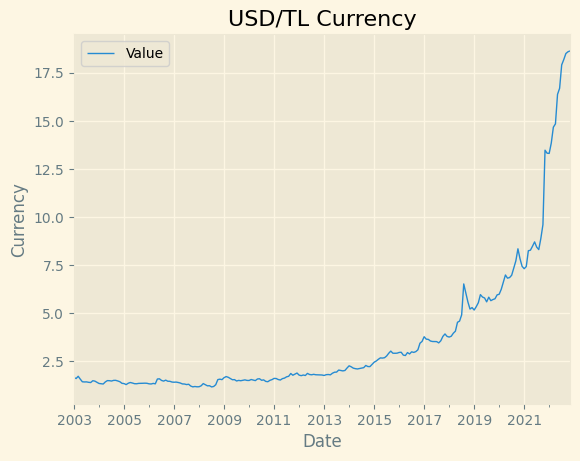

In [112]:
df5.plot()
plt.xlabel('Date')
plt.ylabel('Currency')
plt.title("USD/TL Currency")


## Predicting USD/TL Currency

In [113]:

from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df5.Value)

Test Statistic                   4.656086
p-value                          1.000000
#Lags Used                      12.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64

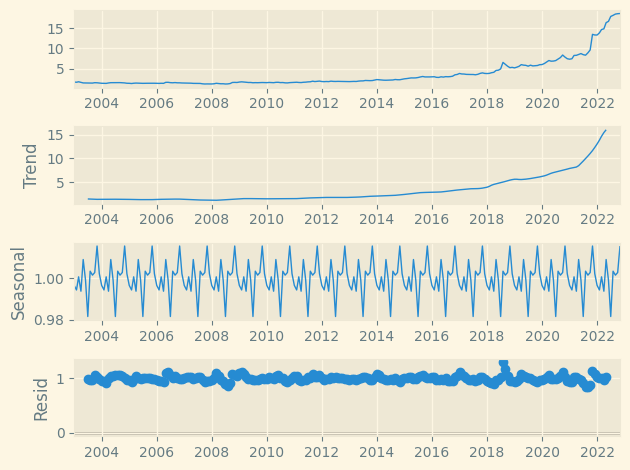

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df5, model='multiplicative')



plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available)

In [115]:
from pmdarima.arima import auto_arima

results = auto_arima(df5, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=304.725, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=207.831, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=189.020, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=301.670, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=189.158, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=189.155, Time=0.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=208.081, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=189.086, Time=1.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=191.221, Time=0.24 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=186.816, Time=0.59 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=301.650, Time=0.08 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=186.773, Time=0.80 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=208.104, Time=0.23 sec
 ARIMA(0,1,2)(2,1,1)[12]             

In [116]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df5.astype(float),
                                order=(1,1,2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


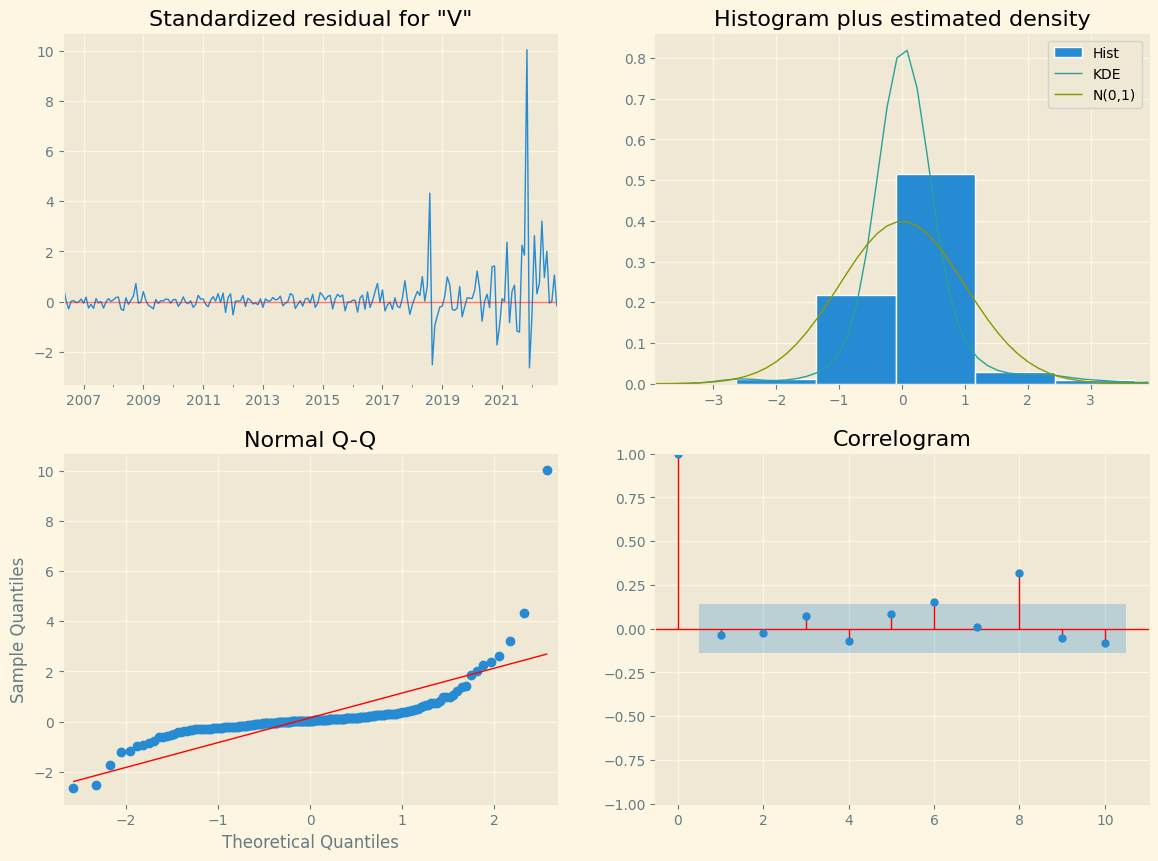

In [117]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

In [118]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [119]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df5['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2022-02-01,12.195061,13.604308,12.899685,13.8443,-6.823136
2022-03-01,13.854110,15.263358,14.558734,14.6700,-0.758458
2022-04-01,13.875974,15.285221,14.580597,14.8416,-1.758588
2022-05-01,14.516578,15.925825,15.221202,16.3748,-7.044962
2022-06-01,15.642312,17.051559,16.346936,16.6933,-2.074871
2022-07-01,16.484914,17.894161,17.189538,17.9114,-4.030184
2022-08-01,17.503503,18.912750,18.208126,18.1868,0.117263
2022-09-01,17.791679,19.200927,18.496303,18.5000,-0.019982
2022-10-01,17.506103,18.915350,18.210726,18.5920,-2.050740
2022-11-01,18.001142,19.410390,18.705766,18.6367,0.370591


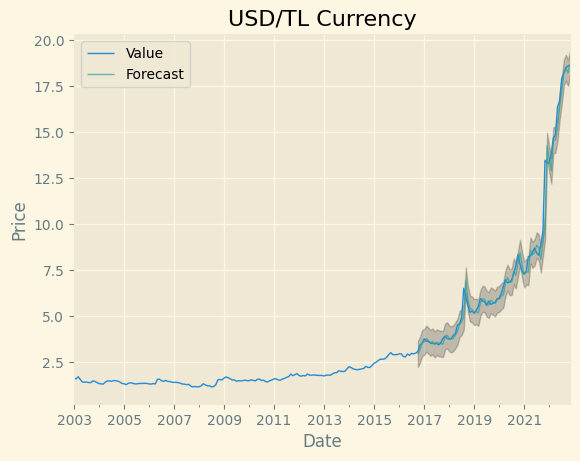

In [120]:
ax = df5['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL Currency")
plt.legend()
plt.show()

In [127]:
# Get forecast in future
pred_uc = results.get_forecast(steps=13)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

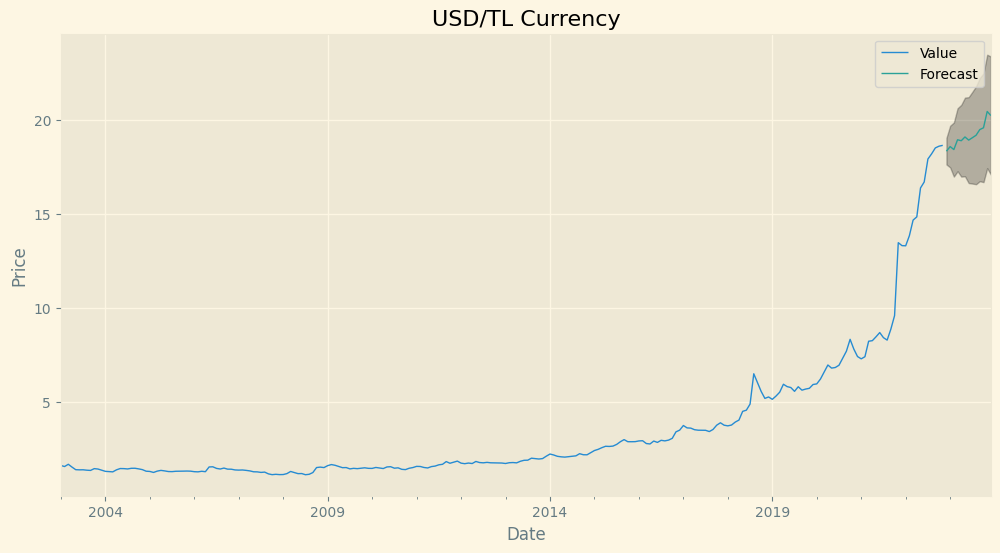

In [128]:
ax = df5.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL Currency")

plt.legend()

plt.show()

In [129]:
pred_ci

,lower Value,upper Value
2022-12-01,17.621321,19.030569
2023-01-01,17.466442,19.674794
2023-02-01,16.978401,19.849286
2023-03-01,17.262612,20.602360
2023-04-01,16.977514,20.785065
2023-05-01,16.995032,21.169794
2023-06-01,16.636708,21.192203
2023-07-01,16.607779,21.476178
2023-08-01,16.574378,21.771243
2023-09-01,16.735025,22.209715


Text(0.5, 1.0, 'USD/TL Currency')

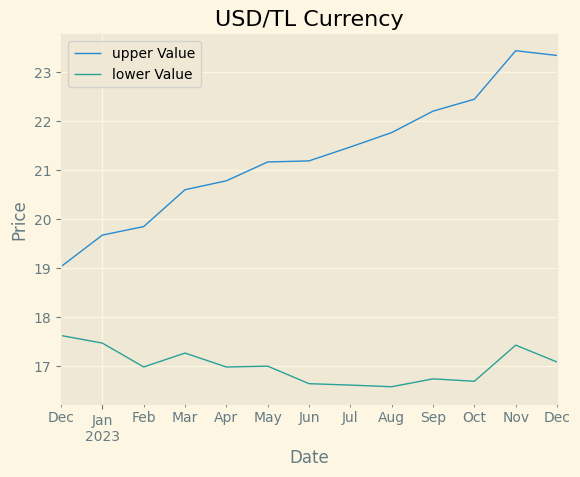

In [130]:
pred_ci[["upper Value","lower Value"]].head(24).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL Currency")

In [145]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Mean']

2022-12-01    18.325945
2023-01-01    18.570618
2023-02-01    18.413844
2023-03-01    18.932486
2023-04-01    18.881289
2023-05-01    19.082413
2023-06-01    18.914455
2023-07-01    19.041979
2023-08-01    19.172811
2023-09-01    19.472370
2023-10-01    19.569435
2023-11-01    20.434721
2023-12-01    20.213785
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'USD/TL Currency Prediction for next 24 months')

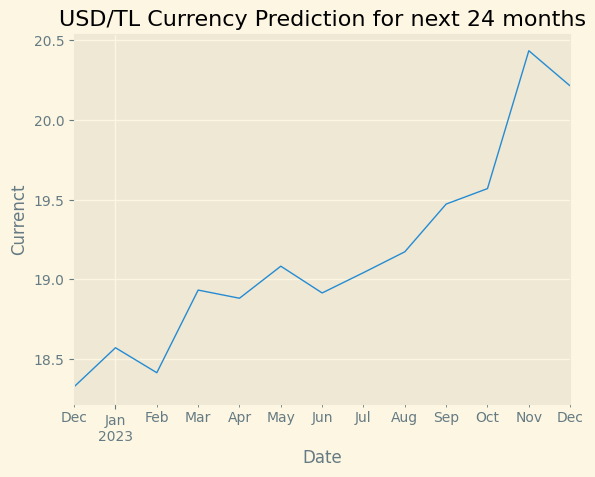

In [146]:
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Currenct')
plt.title("USD/TL Currency Prediction for next 24 months")

In [147]:
cur=df5["Value"].iloc[232:]
cur=pd.DataFrame(cur)
cur

,Value
TIME,
2022-05-01,16.3748
2022-06-01,16.6933
2022-07-01,17.9114
2022-08-01,18.1868
2022-09-01,18.5000
2022-10-01,18.5920
2022-11-01,18.6367


In [179]:
dates= pd.date_range('2022-12-01','2024-01-01' , freq='1M')-pd.offsets.MonthBegin(1)
cur_pred=pd.DataFrame()
cur_pred["TIME"]=dates
cur_pred["Value"]=pred_ci["Mean"].values
cur_pred=cur_pred.set_index(dates)
cur_pred

,TIME,Value
2022-12-01,2022-12-01,18.325945
2023-01-01,2023-01-01,18.570618
2023-02-01,2023-02-01,18.413844
2023-03-01,2023-03-01,18.932486
2023-04-01,2023-04-01,18.881289
2023-05-01,2023-05-01,19.082413
2023-06-01,2023-06-01,18.914455
2023-07-01,2023-07-01,19.041979
2023-08-01,2023-08-01,19.172811
2023-09-01,2023-09-01,19.472370


In [180]:
cur_pred['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
cur_pred['TIME'] =  pd.to_datetime(cur_pred['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
cur_pred = cur_pred.set_index(['TIME'])
cur_pred

,Value
TIME,
2022-12-01,18.325945
2023-01-01,18.570618
2023-02-01,18.413844
2023-03-01,18.932486
2023-04-01,18.881289
2023-05-01,19.082413
2023-06-01,18.914455
2023-07-01,19.041979
2023-08-01,19.172811


In [183]:
#Combining estimated data with actual data from April to December
currency_predicted=pd.concat([cur,cur_pred],axis=0)
currency_predicted

,Value
TIME,
2022-05-01,16.374800
2022-06-01,16.693300
2022-07-01,17.911400
2022-08-01,18.186800
2022-09-01,18.500000
2022-10-01,18.592000
2022-11-01,18.636700
2022-12-01,18.325945
2023-01-01,18.570618


## Brent Petrol Price Prediction

In [208]:

dates=pd.date_range('2003-01-01','2023-01-01' , freq='1M')-pd.offsets.MonthBegin(1)
df2=pd.DataFrame()
df2['TIME']=dates
df2['Value']=brent.values
df2

,TIME,Value
0,2003-01-01,31.10
1,2003-02-01,32.79
2,2003-03-01,27.18
3,2003-04-01,23.68
4,2003-05-01,26.32
...,...,...
235,2022-08-01,95.64
236,2022-09-01,85.14
237,2022-10-01,94.83
238,2022-11-01,85.43


In [209]:
df2['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df2['TIME'] =  pd.to_datetime(df2['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df2 = df2.set_index(['TIME'])

In [210]:
df2['Value']=df2['Value'].astype(float)

Text(0.5, 1.0, 'Brent Petrol Price($)')

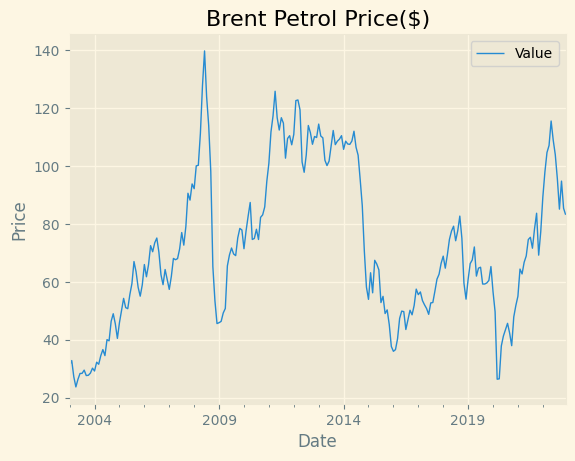

In [211]:
df2.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

In [212]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df2.Value)

Test Statistic                  -2.741974
p-value                          0.067052
#Lags Used                       1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64

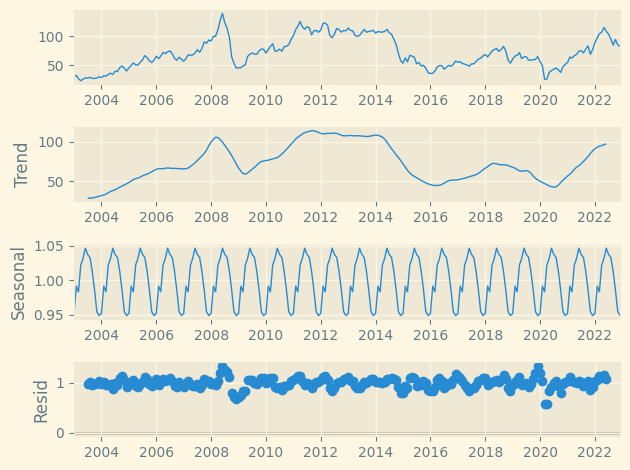

In [213]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2, model='multiplicative')



plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available

In [214]:
from pmdarima.arima import auto_arima

results = auto_arima(df2, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1662.183, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1591.196, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1649.707, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1565.777, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1580.034, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1567.702, Time=0.41 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1567.699, Time=0.46 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1566.239, Time=0.32 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1566.688, Time=2.34 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=1567.777, Time=0.96 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

In [216]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df2.astype(float),
                                order=(1,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


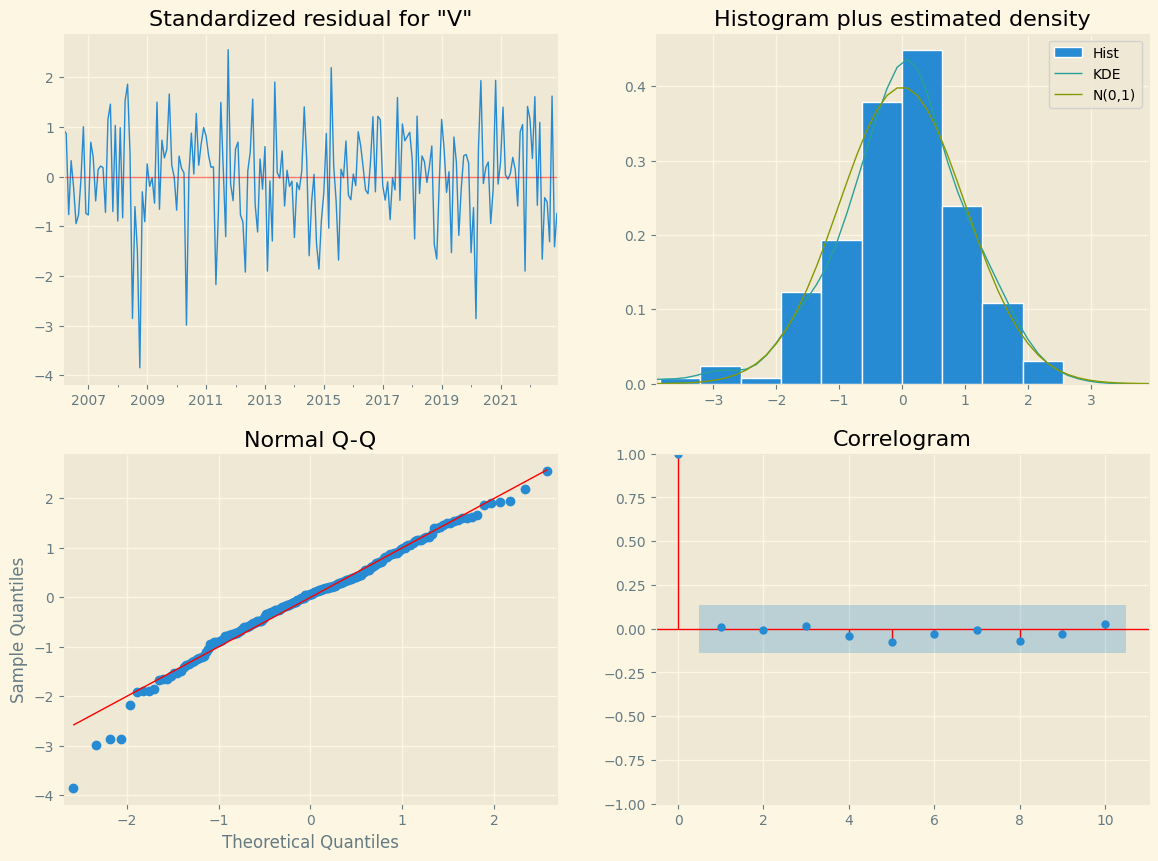

In [217]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

In [218]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [220]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df2['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2022-03-01,77.453654,107.384990,92.419322,104.71,-11.737826
2022-04-01,96.583564,126.514900,111.549232,107.14,4.115393
2022-05-01,92.304281,122.235617,107.269949,115.60,-7.205926
2022-06-01,106.754140,136.685476,121.719808,109.03,11.638822
2022-07-01,92.238509,122.169845,107.204177,103.97,3.110683
2022-08-01,84.571816,114.503151,99.537484,95.64,4.075161
2022-09-01,80.191685,110.123021,95.157353,85.14,11.765742
2022-10-01,67.485690,97.417026,82.451358,94.83,-13.053509
2022-11-01,81.249904,111.181240,96.215572,85.43,12.625041
2022-12-01,73.761746,103.693081,88.727413,83.18,6.669167


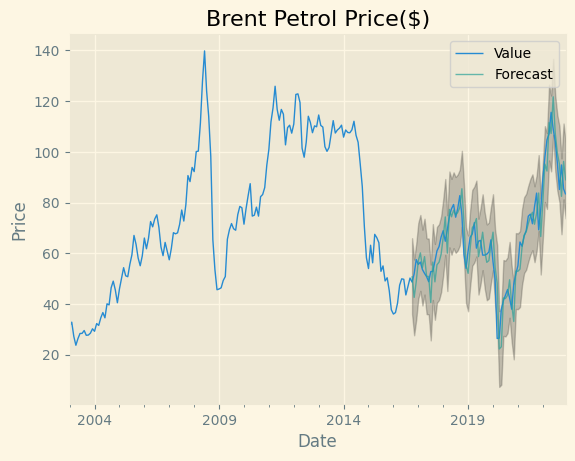

In [221]:
ax = df2['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [222]:
# Get forecast in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

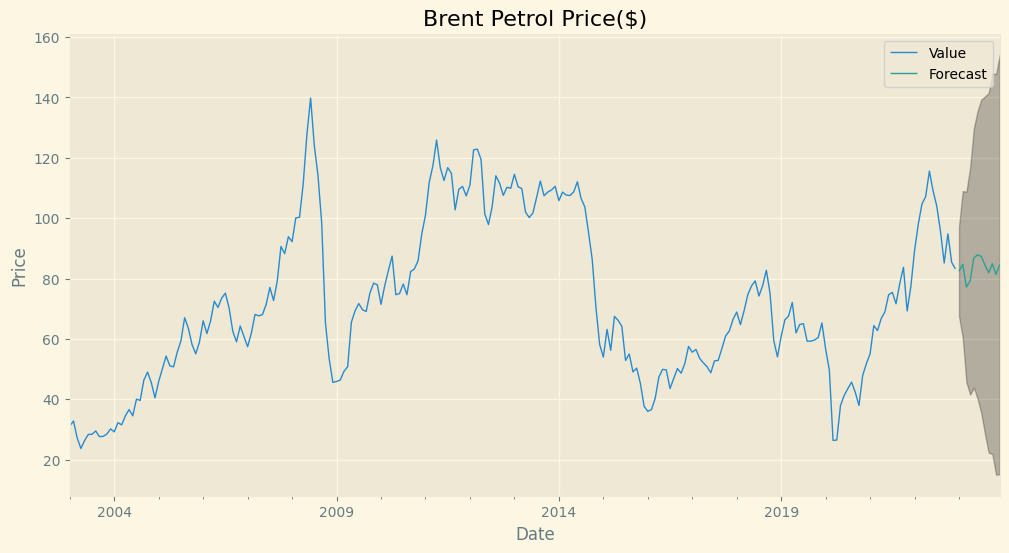

In [223]:
ax = df2.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [224]:
pred_ci

,lower Value,upper Value
2023-01-01,67.429101,97.360437
2023-02-01,60.455135,108.971219
2023-03-01,45.614028,108.785412
2023-04-01,41.510115,116.866418
2023-05-01,43.878284,129.789613
2023-06-01,40.165364,135.490467
2023-07-01,35.406288,139.300848
2023-08-01,28.519020,140.329501
2023-09-01,22.301826,141.504049
2023-10-01,21.821490,147.983207


Text(0.5, 1.0, 'Brent Petrol Price($)')

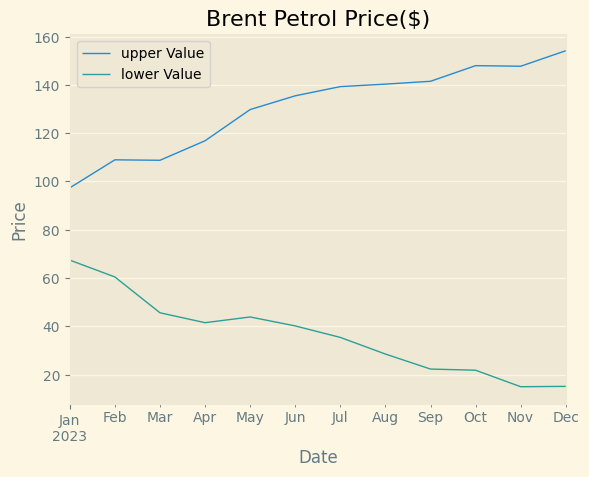

In [225]:
pred_ci[["upper Value","lower Value"]].head(24).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

In [226]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [227]:
pred_ci['Mean']

2023-01-01    82.394769
2023-02-01    84.713177
2023-03-01    77.199720
2023-04-01    79.188266
2023-05-01    86.833948
2023-06-01    87.827915
2023-07-01    87.353568
2023-08-01    84.424260
2023-09-01    81.902938
2023-10-01    84.902349
2023-11-01    81.361045
2023-12-01    84.647671
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'Brent Petrol Price Prediction for next 12 months')

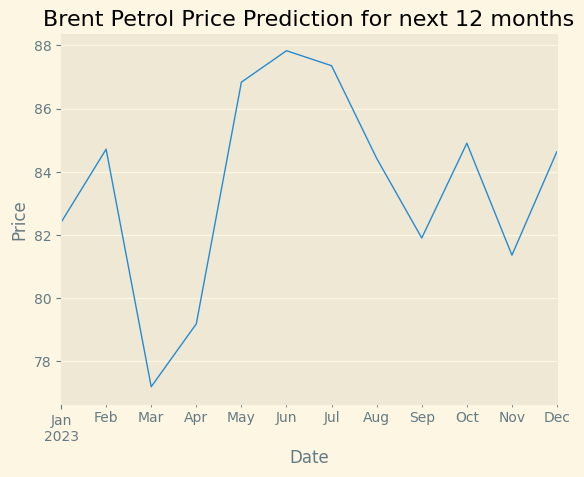

In [228]:
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price Prediction for next 12 months")

In [250]:
br=df2["Value"].iloc[232:]
br=pd.DataFrame(br)
br["Value"]=br["Value"].astype(float)
br

,Value
TIME,
2022-05-01,115.60
2022-06-01,109.03
2022-07-01,103.97
2022-08-01,95.64
2022-09-01,85.14
2022-10-01,94.83
2022-11-01,85.43
2022-12-01,83.18


In [257]:
dates= pd.date_range('2023-01-01','2024-01-01' , freq='1M')-pd.offsets.MonthBegin(1)
brent_pred=pd.DataFrame()
brent_pred["TIME"]=dates
brent_pred["Value"]=pred_ci["Mean"].values
brent_pred=brent_pred.set_index(dates)
brent_pred["Value"]=brent_pred["Value"].astype(float)
brent_pred

,TIME,Value
2023-01-01,2023-01-01,82.394769
2023-02-01,2023-02-01,84.713177
2023-03-01,2023-03-01,77.199720
2023-04-01,2023-04-01,79.188266
2023-05-01,2023-05-01,86.833948
2023-06-01,2023-06-01,87.827915
2023-07-01,2023-07-01,87.353568
2023-08-01,2023-08-01,84.424260
2023-09-01,2023-09-01,81.902938
2023-10-01,2023-10-01,84.902349


In [258]:
brent_pred['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
brent_pred['TIME'] =  pd.to_datetime(brent_pred['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
brent_pred = brent_pred.set_index(['TIME'])
brent_pred

,Value
TIME,
2023-01-01,82.394769
2023-02-01,84.713177
2023-03-01,77.199720
2023-04-01,79.188266
2023-05-01,86.833948
2023-06-01,87.827915
2023-07-01,87.353568
2023-08-01,84.424260
2023-09-01,81.902938


In [259]:
#Combining estimated data with actual data from April to December
brent_predicted=pd.concat([br,brent_pred],axis=0)
brent_predicted

,Value
TIME,
2022-05-01,115.600000
2022-06-01,109.030000
2022-07-01,103.970000
2022-08-01,95.640000
2022-09-01,85.140000
2022-10-01,94.830000
2022-11-01,85.430000
2022-12-01,83.180000
2023-01-01,82.394769


## Predicting Electricity Price

In [261]:

from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df3.Value)

Test Statistic                   1.912999
p-value                          0.998549
#Lags Used                      15.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64

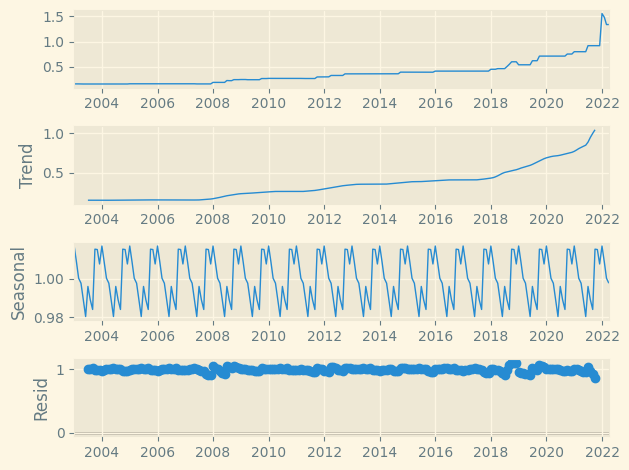

In [262]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df3, model='multiplicative')



plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available)

In [263]:
from pmdarima.arima import auto_arima

results = auto_arima(df3, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-734.058, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-731.748, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-729.047, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-729.853, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-735.882, Time=0.20 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-734.215, Time=0.55 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-740.194, Time=1.22 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-745.763, Time=2.64 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-740.132, Time=1.56 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-750.604, Time=3.03 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-742.766, Time=2.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-748.254, Time=3.52 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-747.741, Time=3.21 sec
 ARIMA(2,1,1)(1,1,2)[12]

In [265]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


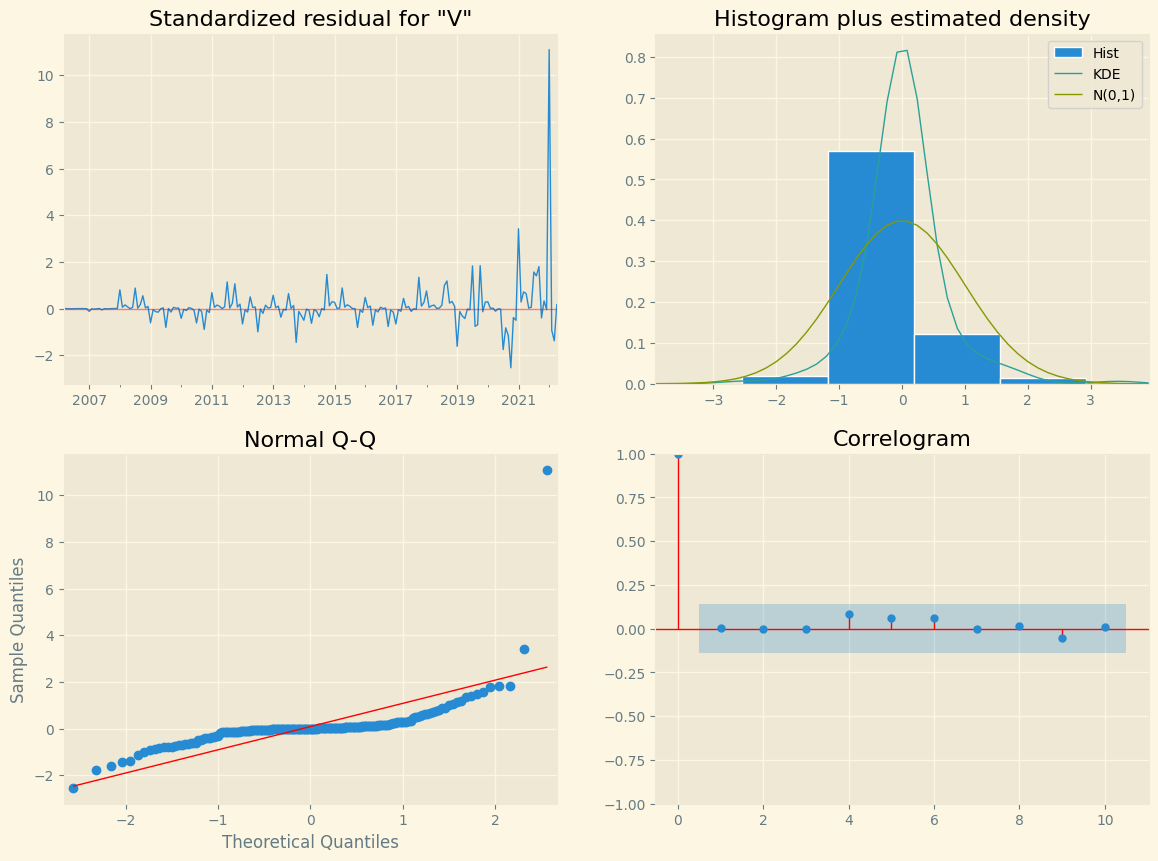

In [266]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

In [267]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [269]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df3['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2021-07-01,0.769772,0.933609,0.851691,0.9172,-7.142299
2021-08-01,0.776627,0.940464,0.858545,0.9172,-6.394953
2021-09-01,0.759999,0.923836,0.841918,0.9172,-8.207813
2021-10-01,0.851946,1.015783,0.933865,0.9172,1.816901
2021-11-01,0.821488,0.985324,0.903406,0.9172,-1.503928
2021-12-01,0.837027,1.000864,0.918945,0.9172,0.190258
2022-01-01,1.010311,1.174148,1.092229,1.5562,-29.814352
2022-02-01,1.437890,1.601726,1.519808,1.4809,2.627322
2022-03-01,1.312900,1.476737,1.394818,1.3372,4.308885
2022-04-01,1.246941,1.410778,1.328859,1.3372,-0.623755


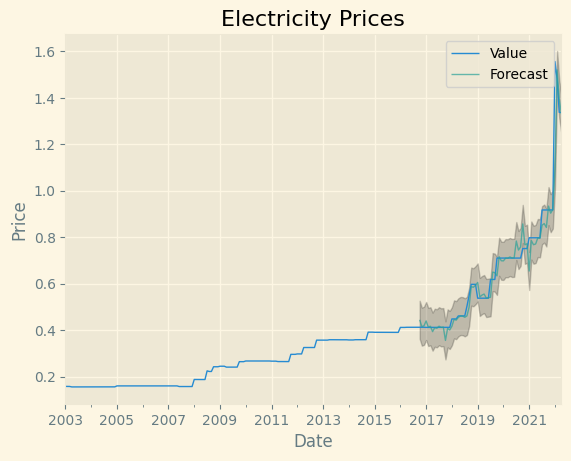

In [270]:
ax = df3['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Electricity Prices")
plt.legend()
plt.show()

In [271]:
# Get forecast in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

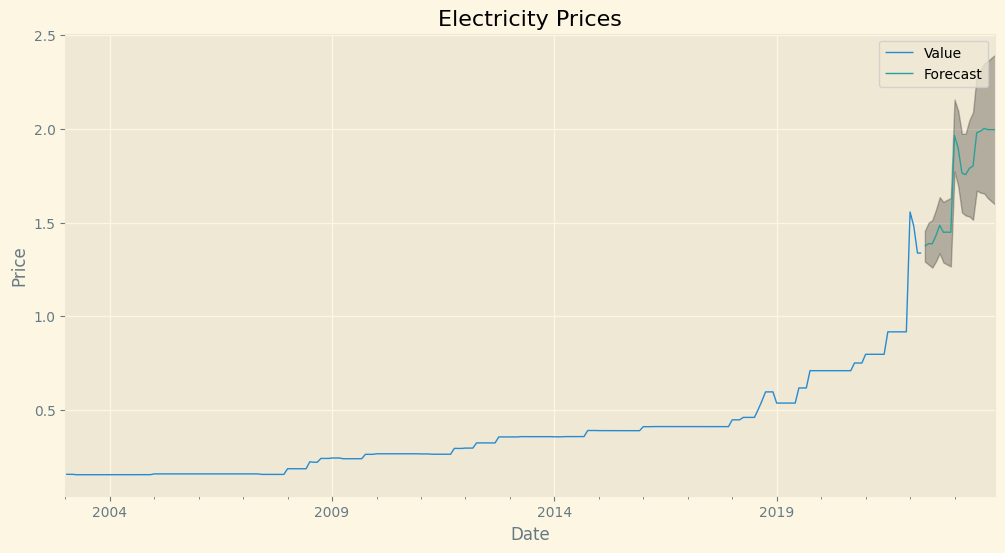

In [273]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Electricity Prices")

plt.legend()

plt.show()

In [274]:
pred_ci

,lower Value,upper Value
2022-05-01,1.291840,1.455677
2022-06-01,1.275916,1.498786
2022-07-01,1.260029,1.513093
2022-08-01,1.292902,1.568335
2022-09-01,1.335776,1.635022
2022-10-01,1.286611,1.609618
2022-11-01,1.276023,1.620848
2022-12-01,1.265611,1.630412
2023-01-01,1.771628,2.155320
2023-02-01,1.693744,2.095564


Text(0.5, 1.0, 'Electricity Prices')

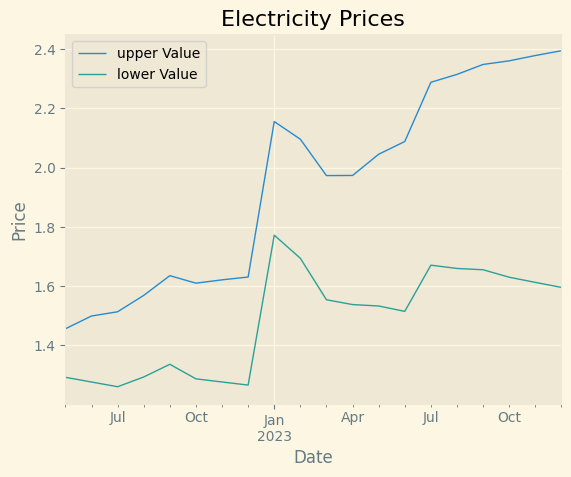

In [275]:
pred_ci[["upper Value","lower Value"]].head(24).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Electricity Prices")

In [276]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [277]:
pred_ci['Mean']

2022-05-01    1.373758
2022-06-01    1.387351
2022-07-01    1.386561
2022-08-01    1.430619
2022-09-01    1.485399
2022-10-01    1.448115
2022-11-01    1.448436
2022-12-01    1.448011
2023-01-01    1.963474
2023-02-01    1.894654
2023-03-01    1.763257
2023-04-01    1.755340
2023-05-01    1.788754
2023-06-01    1.801153
2023-07-01    1.979129
2023-08-01    1.986894
2023-09-01    2.001485
2023-10-01    1.994966
2023-11-01    1.995260
2023-12-01    1.994872
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'Electricity Price Prediction for next 20 months')

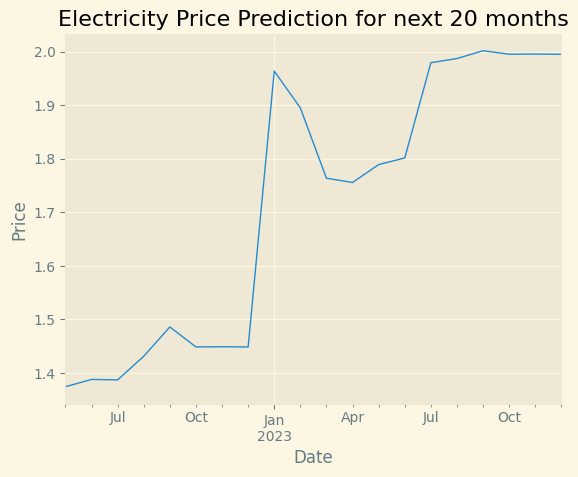

In [278]:
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Electricity Price Prediction for next 20 months")

In [286]:
elektrik_predicted=pred_ci["Mean"]


## Predicting Natural Gas Price

In [287]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df4.Value)

Test Statistic                   3.091589
p-value                          1.000000
#Lags Used                       4.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64

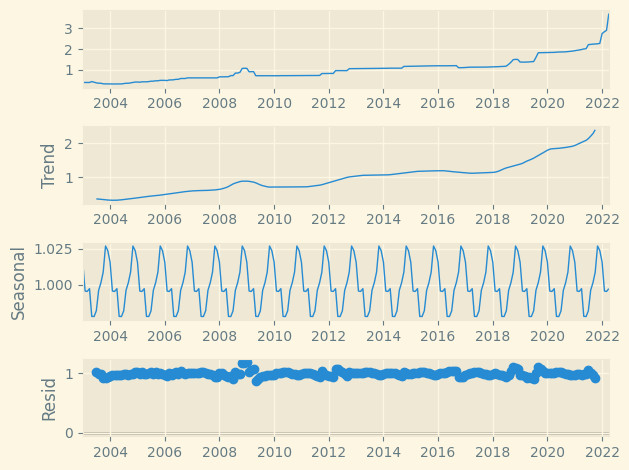

In [288]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df4, model='multiplicative')



plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available)

In [289]:
from pmdarima.arima import auto_arima

results = auto_arima(df4, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-511.172, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-477.333, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-490.533, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-497.606, Time=0.53 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-489.596, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-511.760, Time=1.72 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-498.133, Time=0.51 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-510.309, Time=3.80 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-510.039, Time=2.75 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-512.043, Time=2.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-497.401, Time=1.91 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-496.784, Time=1.22 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=3.60 sec
 ARIMA(0,1,0)(0,1,2)[12]     

In [294]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df4.astype(float),
                                order=(3,1,3),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


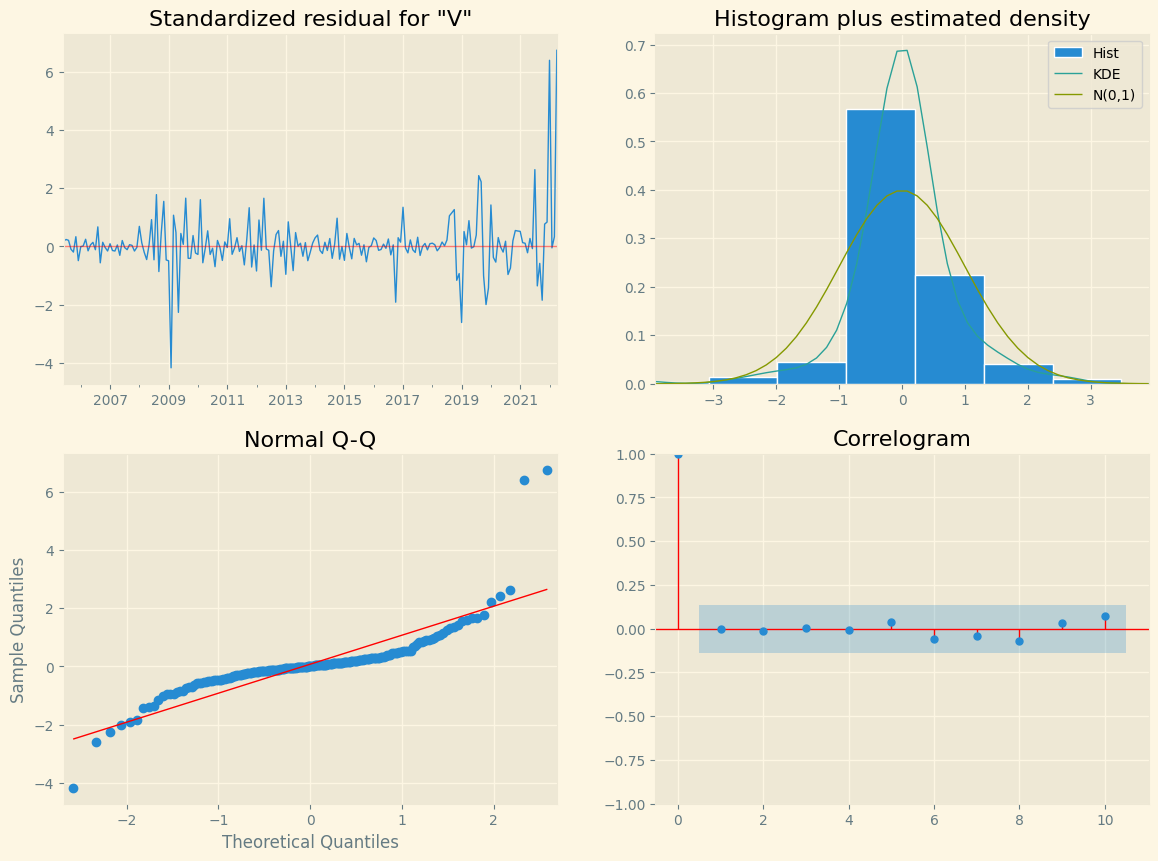

In [295]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

In [296]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [297]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df4['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2021-07-01,1.905302,2.169972,2.037637,2.2160,-8.048869
2021-08-01,2.188928,2.453597,2.321262,2.2298,4.101816
2021-09-01,2.146497,2.411166,2.278831,2.2396,1.751704
2021-10-01,2.241877,2.506547,2.374212,2.2495,5.543987
2021-11-01,2.072054,2.336723,2.204388,2.2563,-2.300752
2021-12-01,2.086680,2.351349,2.219015,2.2757,-2.490894
2022-01-01,2.187008,2.451677,2.319342,2.7515,-15.706254
2022-02-01,2.711970,2.976639,2.844305,2.8411,0.112796
2022-03-01,2.752071,3.016740,2.884405,2.9071,-0.780659
2022-04-01,3.129575,3.394243,3.261909,3.7188,-12.285979


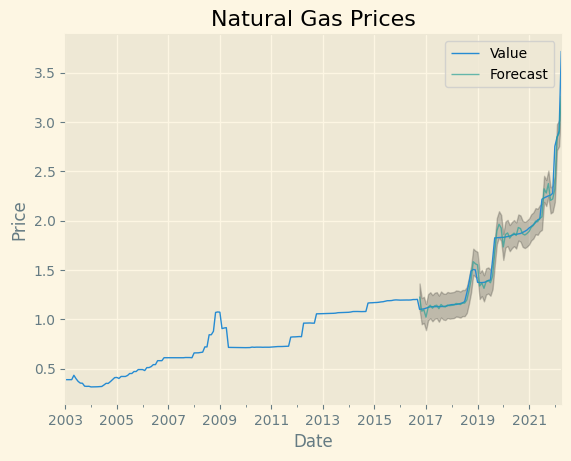

In [298]:
ax = df4['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Natural Gas Prices")
plt.legend()
plt.show()

In [299]:
# Get forecast in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

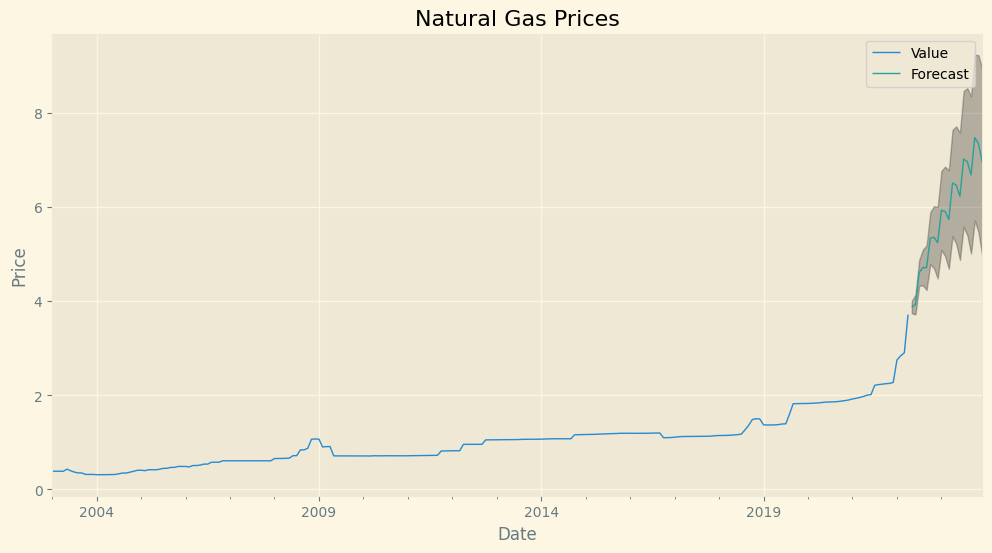

In [300]:
ax = df4.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Natural Gas Prices")

plt.legend()

plt.show()

In [301]:
pred_ci

,lower Value,upper Value
2022-05-01,3.745495,4.010159
2022-06-01,3.722909,4.143087
2022-07-01,4.331146,4.879913
2022-08-01,4.338621,5.100288
2022-09-01,4.244099,5.192716
2022-10-01,4.791552,5.895432
2022-11-01,4.701240,6.024455
2022-12-01,4.488187,6.008127
2023-01-01,5.092078,6.775468
2023-02-01,4.962899,6.864237


Text(0.5, 1.0, 'Natural Gas Prices')

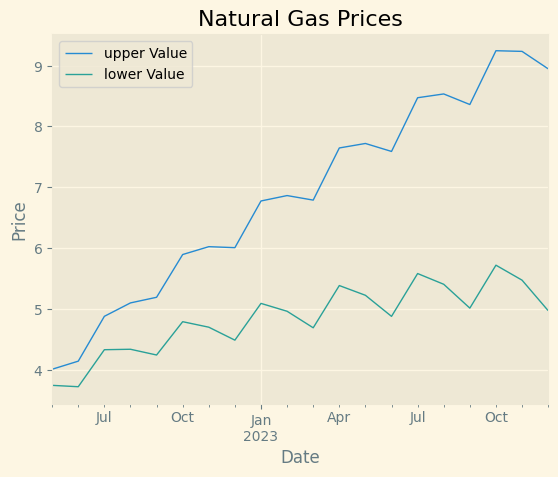

In [302]:
pred_ci[["upper Value","lower Value"]].head(24).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Natural Gas Prices")

In [303]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [304]:
pred_ci['Mean']

2022-05-01    3.877827
2022-06-01    3.932998
2022-07-01    4.605530
2022-08-01    4.719455
2022-09-01    4.718407
2022-10-01    5.343492
2022-11-01    5.362847
2022-12-01    5.248157
2023-01-01    5.933773
2023-02-01    5.913568
2023-03-01    5.740562
2023-04-01    6.516076
2023-05-01    6.472922
2023-06-01    6.234322
2023-07-01    7.027476
2023-08-01    6.970357
2023-09-01    6.687564
2023-10-01    7.482401
2023-11-01    7.353984
2023-12-01    6.960307
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'Natural Gas Price Prediction for next 20 months')

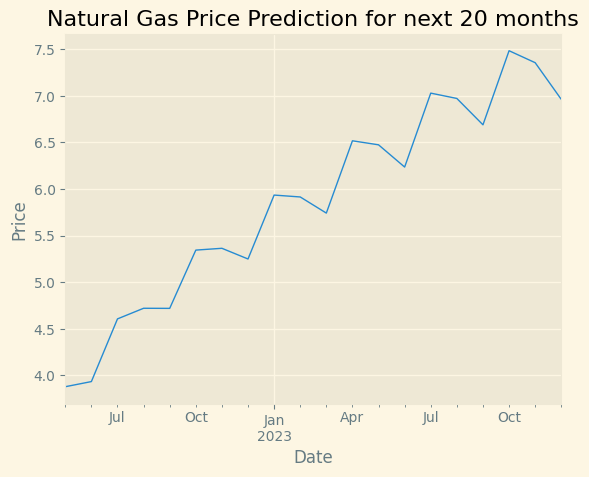

In [305]:
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Natural Gas Price Prediction for next 20 months")

In [306]:
natural_predicted=pred_ci["Mean"]

## Building the post-estimate regression model for average food price with predicted data

In [340]:
y=np.array(food_predicted.values)
x1=np.array(pd.DataFrame(currency_predicted.values))
x2=np.array(pd.DataFrame(brent_predicted.values))
x3=np.array(pd.DataFrame(elektrik_predicted.values))
x4=np.array(pd.DataFrame(natural_predicted.values))
X=np.concatenate([x1,x2,x3,x4],axis=1)
const=sm.add_constant(X)
model=sm.OLS(y,const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     37.98
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           1.11e-07
Time:                        21:25:18   Log-Likelihood:                -81.924
No. Observations:                  20   AIC:                             173.8
Df Residuals:                      15   BIC:                             178.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -981.8569    215.489     -4.556      0.0

After estimating the average food prices, when we put the USD/TL, brent petrol, electricity and natural gas price estimations into the regression model, we see that the strong relationship between them continues. We can say that our models work successfully.